# 102 Flower Classification using ResNet50 

## 1. Prepare data

In [1]:
import os
from pathlib import Path
import scipy

### 1.1 Extracting data into train, test, and validation sets
We'll follow these steps:
1. Get the indices of labels, train, test, and validation images from the respective mat files.
2. Get the path of all the images to map the indices
3. Finally, map the indices with the list to get the respective train, test, and validation sets along with their labels.

In [2]:
# Let's load the mat files for labels and data split
labels_mat = scipy.io.loadmat('data/imagelabels.mat')
split_mat = scipy.io.loadmat('data/setid.mat')
print(f"Keys of labels mat file:\n{labels_mat.keys()}")
print(f"Keys of split mat file:\n{split_mat.keys()}")


Keys of labels mat file:
dict_keys(['__header__', '__version__', '__globals__', 'labels'])
Keys of split mat file:
dict_keys(['__header__', '__version__', '__globals__', 'trnid', 'valid', 'tstid'])


In [3]:
# Let's extract the label, train, test, and validation sets indices
labels = labels_mat['labels'].flatten() # remove that extra 1 dimension
train_idx = split_mat['trnid'].flatten()
val_idx = split_mat['valid'].flatten()
test_idx = split_mat['tstid'].flatten()

# Observe the shape to get the idea of the train, test, and validation sets sizes
print(f"Label shape: {labels.shape}")
print(f"Train data indices shape: {train_idx.shape}")
print(f"Validation data indices shape: {val_idx.shape}")
print(f"Test data indices shape: {test_idx.shape}\n")

# Let's print the indices
print(f"Labels:\n{labels[:5]}")
print(f"Train idices:\n{train_idx[:5]}")
print(f"Validation idices:\n{val_idx[:5]}")
print(f"Test idices:\n{test_idx[:5]}")



Label shape: (8189,)
Train data indices shape: (1020,)
Validation data indices shape: (1020,)
Test data indices shape: (6149,)

Labels:
[77 77 77 77 77]
Train idices:
[6765 6755 6768 6736 6744]
Validation idices:
[6773 6767 6739 6749 6763]
Test idices:
[6734 6735 6737 6742 6743]


In [4]:
# Let's see what the indices of array start from 
labels.min(), train_idx.min(), test_idx.min(), val_idx.min()

(1, 28, 1, 17)

Here, we can see the indices of images start from 1 

In [5]:
# Set the path to all the images 
image_path = Path("data/raw")

# Retrieve the paths of all the images in the dataset
image_paths = sorted(list(image_path.glob("*.jpg")))  # get all the files with '.jpg' extension
image_paths[:10], len(image_paths)

([WindowsPath('data/raw/image_00001.jpg'),
  WindowsPath('data/raw/image_00002.jpg'),
  WindowsPath('data/raw/image_00003.jpg'),
  WindowsPath('data/raw/image_00004.jpg'),
  WindowsPath('data/raw/image_00005.jpg'),
  WindowsPath('data/raw/image_00006.jpg'),
  WindowsPath('data/raw/image_00007.jpg'),
  WindowsPath('data/raw/image_00008.jpg'),
  WindowsPath('data/raw/image_00009.jpg'),
  WindowsPath('data/raw/image_00010.jpg')],
 8189)

In [6]:
# Let's split the images into train, test, and validation sets
train_images = [image_paths[i-1] for i in train_idx]  # min index is 1. So, starting with i-1
train_labels = [labels[i-1] for i in train_idx]

test_images = [image_paths[i-1] for i in test_idx]
test_labels = [labels[i-1] for i in test_idx]

val_images = [image_paths[i-1] for i in val_idx]
val_labels = [labels[i-1] for i in val_idx]

print(f"Train images length: {len(train_images)}")
print(f"Train labels length: {len(train_labels)}")

print(f"Validation images indices length: {len(val_images)}")
print(f"Validation labels length: {len(val_labels)}")

print(f"Test images length: {len(test_images)}")
print(f"Test labels length: {len(test_labels)}\n")




Train images length: 1020
Train labels length: 1020
Validation images indices length: 1020
Validation labels length: 1020
Test images length: 6149
Test labels length: 6149



### 1.2 Prepare a pytorch custom dataset
In this section, we are going to:
1. Build a custom dataset class
2. Use auto transform 
3. Make an instance of the custom dataset and apply the defined transformation

In [7]:
from torchvision import transforms

### USING AUTO TRANSFORM 
import torchvision.models as models

# Load ResNet50 with pretrained weights
weights = models.ResNet50_Weights.DEFAULT  

# Get the transformation associated with the weights
auto_transform = weights.transforms()

# 2.3 Define train transform 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly resize and crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ToTensor(),  # Convert the images to tensor
    transforms.Normalize(mean=auto_transform.mean, std=auto_transform.std)
])

# Define validation transform 
val_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=auto_transform.mean, std=auto_transform.std)
])

In [8]:
from data_loader import ImageDataset

# Create train, test, and validation dataset
train_data = ImageDataset(train_images, train_labels, train_transform)
val_data = ImageDataset(val_images, val_labels, val_transform)
test_data = ImageDataset(test_images, test_labels, val_transform)

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Validation data size: {len(val_data)}")



Train data size: 1020
Test data size: 6149
Validation data size: 1020


### 1.3 Visualize the images
Here, we'll visualize the images and compare the original images with the transformed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.5179958].


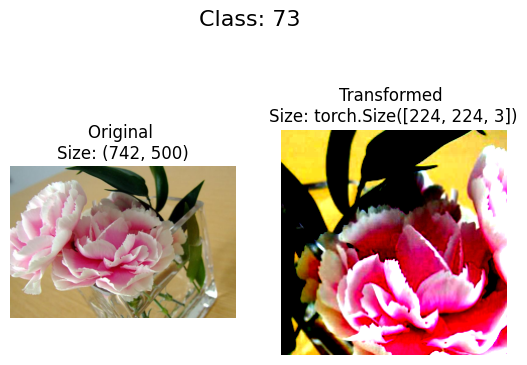

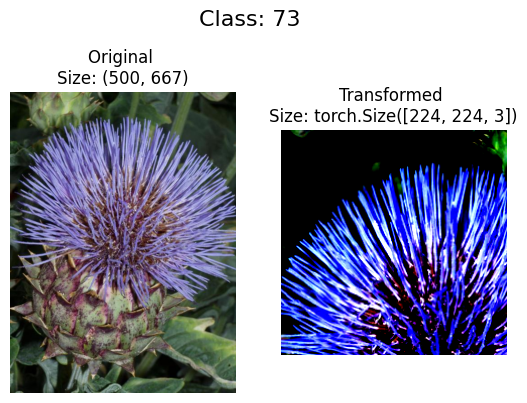

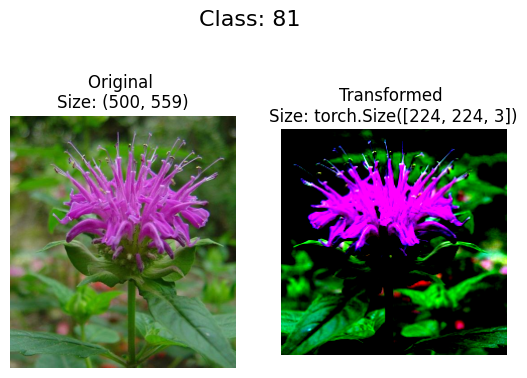

In [9]:
# Import the plot function
from utils import plot_transformed_images

# Plot the original vs transformed image
plot_transformed_images(train_images, labels, transform=train_transform, n=3)

### 1.4 Convert the datasets into DataLoaders
We'll turn our datasets into an iterator and load the images in batches instead of loading the entire dataset at once.

In [10]:
from torch.utils.data import DataLoader
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
# Define train dataloader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

# Define test dataloader
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False   # not really needed to shuffle test data
)

# Define the validation dataloader
val_dataloader = DataLoader(
    dataset=train_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)